# Information about the notebook
The notebook is splitted into 5 parts: <br>
1: Prepare the data <br>
2: Build a simple NN <br>
3: Build a NN with L1/l2 Regularization <br>
4: Build a NN and train it with normalized data <br>
5: Build a RNN <br>

# Basics


In [0]:
#Python packages for preparing the data
import os
import shutil as sys
import glob
import sys
import csv


#Python packages for audio files
import wave
import librosa   #for audio processing
import numpy as np
from scipy.io import wavfile #for audio processing
import pandas as pd



Get the access to Google Drive for the Data

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Preparing the data

## Get the own data from Google drive

Unzip the wav files

In [0]:
#for Google Drive
!unzip -uq '/content/drive/My Drive/labeled_train_own_data.zip'
!unzip -uq '/content/drive/My Drive/labeled_val_own_data.zip'
!unzip -uq '/content/drive/My Drive/labeled_test_own_data.zip'

Delete the __MACOSX folder

In [0]:
!rm -rf __MACOSX/

## Convert the data

### Training and Validation Data

Create a array (label_list) with all the labels

Delete the elements '_background_noise_' and '_other_'

'_background_noise_' --> for Data Augmentation <br>


In [0]:
label_list = os.listdir('/content/labeled_test_own_data')
print("Original:", label_list)
label_list.remove('_background_noise_')
label_list.remove('.DS_Store')
print("Removed:",label_list)

Original: ['stop', '.DS_Store', 'balls_screw_drive', 'measurement_system', 'alert', 'error_logs', 'air_pressure_alert', 'nc_alert', '_background_noise_', 'cnc', 'reutlingen']
Removed: ['stop', 'balls_screw_drive', 'measurement_system', 'alert', 'error_logs', 'air_pressure_alert', 'nc_alert', 'cnc', 'reutlingen']


Function to create an array with all the samples with sample_rate = 8000 and an array with all the labels

In [0]:
def create_array_with_samples(label_list, audio_path):

  length = 0
  all_wave = []
  all_label = []

  for label in label_list:
      print("Label: ", label)
      waves = [f for f in os.listdir(audio_path + '/'+ label) if f.endswith('.wav')]
      #Get the number of all files
      length += len(waves)

      for wav in waves:
          #Get sample rate
          with wave.open(audio_path + '/' + label + '/' + wav, "rb") as wave_file:
              frame_rate = wave_file.getframerate()

          #Extract samples in array
          samples, sample_rate = librosa.load(audio_path + '/' + label + '/' + wav, sr = frame_rate)
          samples = librosa.resample(samples, len(samples), 8000)
          
          if(len(samples)== 8000) : 
              all_wave.append(samples)
              all_label.append(label)
          else:
            print("Wrong Sample Rate:", len(samples)," File:", label + "/" + wav)

  return all_wave, all_label, length

Use the function for all 3 partitions

In [0]:
#Train
print("1: Train")
all_wave_train, all_label_train, length = create_array_with_samples(label_list, '/content/labeled_train_own_data')
#Check the sizes
#Print the length of the arrays
print("Length all_wave_train array", type(all_wave_train), len(all_wave_train), all_wave_train[1].shape)
print("Length all_label_orginal", type(all_label_train), len(all_label_train))
print("Loops: ", length)

#Validation
print("2: Validation")
all_wave_val, all_label_val, length = create_array_with_samples(label_list, '/content/labeled_val_own_data')
#Check the sizes
#Print the length of the arrays
print("Length all_wave_val array", type(all_wave_val), len(all_wave_val))
print("Length all_label_val", type(all_label_val), len(all_label_val))
print("Loops: ", length)


### Test Data

In [0]:
#Test
print("1: Test")
all_wave_test, all_label_test, length = create_array_with_samples(label_list, '/content/labeled_test_own_data')
#Check the sizes
#Print the length of the arrays
print("Length all_wave_test array", type(all_wave_test), len(all_wave_test))
print("Length all_label_test", type(all_label_test), len(all_label_test))
print("Loops: ", length)

1: Test
Label:  stop
Label:  balls_screw_drive
Label:  measurement_system
Label:  alert
Label:  error_logs
Label:  air_pressure_alert
Label:  nc_alert
Label:  cnc
Label:  reutlingen
Length all_wave_test array <class 'list'> 18
Length all_label_test <class 'list'> 18
Loops:  18


## Data Augmentation

### Define the functions

In [0]:
#1 Func: Change pitch and speed of the audio files
def pitch_speed_augmentation(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_pitch_speed = []
    all_label_pitch_speed = []

    #Every label folder
    for label in label_list:

            # Path to the files in the folder
            files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

            # For every audio file in folder
            for file in files:
                #Get sample rate
                with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
                  frame_rate = wave_file.getframerate()

                # Read the audio file, extract samples and sample rate & resample to 8000Hz
                samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
                samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

                # Change low and high
                length_change = np.random.uniform(low=0.8, high=1)
                speed_fac = 1.0 / length_change
                #print("resample length_change = ", length_change)
                tmp = np.interp(np.arange(0, len(samples), speed_fac), np.arange(0, len(samples)), samples)
                minlen = min(samples.shape[0], tmp.shape[0])
                samples *= 0
                samples[0:minlen] = tmp[0:minlen]

                #add the new samples and labels in an arrays
                all_wave_train.append(samples)
                all_label_train.append(label)


#2 Func: Change pitch and speed of the audio files
def pitch_augmentation(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_pitch = []
    all_label_pitch = []

    #Every label folder
    for label in label_list:

            # Path to the files in the folder
            files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

            # For every audio file in folder
            for file in files:
                #Get sample rate
                with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
                  frame_rate = wave_file.getframerate()

                # Read the audio file, extract samples and sample rate & resample to 8000Hz
                samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
                samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

                #Change pitch
                bins_per_octave = 12
                pitch_pm = 2
                pitch_change = pitch_pm * 2 * (np.random.uniform())
                #print("pitch_change = ", pitch_change)
                samples = librosa.effects.pitch_shift(samples.astype('float64'),
                                                      sample_rate, n_steps=pitch_change,
                                                      bins_per_octave=bins_per_octave)

                #add the new samples and labels in an arrays
                all_wave_train.append(samples)
                all_label_train.append(label)


#3 Func: Change pitch and speed of the audio files
def speed_augmentation(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_speed = []
    all_label_speed = []

    #Every label folder
    for label in label_list:

            # Path to the files in the folder
            files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

            # For every audio file in folder
            for file in files:
                #Get sample rate
                with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
                  frame_rate = wave_file.getframerate()

                # Read the audio file, extract samples and sample rate & resample to 8000Hz
                samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
                samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

                #Change pitch
                speed_change = np.random.uniform(low=0.9, high=1.1)
                #print("speed_change = ", speed_change)
                tmp = librosa.effects.time_stretch(samples.astype('float64'), speed_change)
                minlen = min(samples.shape[0], tmp.shape[0])
                samples *= 0
                samples[0:minlen] = tmp[0:minlen]

                #add the new samples and labels in an arrays
                all_wave_train.append(samples)
                all_label_train.append(label)


#4 Func: Amplify values in the audio
def amplify_value(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_value = []
    all_label_value = []

    #Every label folder
    for label in label_list:

            # Path to the files in the folder
            files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

            # For every audio file in folder
            for file in files:
                #Get sample rate
                with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
                  frame_rate = wave_file.getframerate()

                # Read the audio file, extract samples and sample rate & resample to 8000Hz
                samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
                samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

                #Amplify value
                dyn_change = np.random.uniform(low=1.5, high=3)
                #print("dyn_change = ", dyn_change)
                samples = samples * dyn_change
                #print(samples[:50])

                # add the new samples and labels in an arrays
                all_wave_train.append(samples)
                all_label_train.append(label)


#5 Func: random shifting in the audio
def random_shifting(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_shift = []
    all_label_shift = []

    #Every label folder
    for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
              frame_rate = wave_file.getframerate()

            # Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
            samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

            #Shift random
            timeshift_fac = 0.2 * 2 * (np.random.uniform() - 0.5)  # up to 20% of length
            #print("timeshift_fac = ", timeshift_fac)
            start = int(samples.shape[0] * timeshift_fac)
            #print(start)
            if (start > 0):
                samples = np.pad(samples, (start, 0), mode='constant')[0:samples.shape[0]]
            else:
                samples = np.pad(samples, (0, -start), mode='constant')[0:samples.shape[0]]

            # add the new samples and labels in an arrays
            all_wave_train.append(samples)
            all_label_train.append(label)


#6 Func: hpss in the audio
def apply_hpss(label_list, data_src_path):

    #Create two empty func output arrays
    all_wave_hpss = []
    all_label_hpss = []

    #Every label folder
    for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
              frame_rate = wave_file.getframerate()

            # Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
            samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

            #hpss
            samples = librosa.effects.hpss(samples)
            samples = samples[1].tolist()

            # add the new samples and labels in an arrays
            all_wave_train.append(samples)
            all_label_train.append(label)



#7 Func: strech the the audio
def strech(label_list, data_src_path):
    # Create two empty func output arrays
    all_wave_strech = []
    all_label_strech = []

    # Every label folder
    for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
              frame_rate = wave_file.getframerate()

            # Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples, sample_rate = librosa.load(data_src_path + '/' + label + '/' + file, sr=frame_rate)
            samples = librosa.resample(samples, len(samples), 8000, res_type='kaiser_best')

            #Shift the silents
            input_length = len(samples)
            samples = librosa.effects.time_stretch(samples, 1.1)
            if len(samples) > input_length:
                samples = samples[:input_length]
            else:
                samples = np.pad(samples, (1, max(1, input_length - len(samples))), "constant")

            # add the new samples and labels in an arrays
            all_wave_train.append(samples)
            all_label_train.append(label)



import random
# entry types => (array, int, list)
def mix_noises_to_audiofiles(data_src_path, noise_src_path,label_list):

    #Create the output arrays
    all_wave_with_noises = []
    all_label_with_noises = []

    # Create a list of all noise files
    noise_list = os.listdir(noise_src_path)
    #Remove folder .DS_Store
    noise_list.remove('.DS_Store')

    # Every label folder
    for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_src_path + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_src_path + '/' + label + '/' + file, "rb") as wave_file:
                frame_rate = wave_file.getframerate()

            #Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples_audio, sample_rate_audio = librosa.load(data_src_path + '/' + label + '/' + file, sr = frame_rate)
            samples_audio = librosa.resample(samples_audio, len(samples_audio), 8000,res_type='kaiser_best')

            # Pick a random noise file
            noise_id = np.random.randint(0, len(noise_list))
            noise_name = noise_list[noise_id]

            #Get sample rate
            with wave.open(noise_src_path + '/' + noise_name, "rb") as wave_file:
                frame_rate_noise = wave_file.getframerate()
            
            # Read the noise file, extract samples and sample rate & resample to 8000Hz
            samples_noise, sample_rate_noise = librosa.load(noise_src_path + '/' + noise_name, sr=frame_rate_noise)
            samples_noise = librosa.resample(samples_noise, len(samples_noise), 8000)

            #Check if the sample_rate of both files is 8000kHz
            if(len(samples_audio)== 8000 and len(samples_noise) == 8000):
                    #Combine the samples from both files
                    combined = samples_audio + samples_noise
            else:
              print('Error: Wrong samples rate --> Audio:', len(samples_audio), "Noise:",len(samples_noise))
              print('Audio:', data_src_path + '/' + label + '/' + file )
              print('Noise:', noise_src_path + '/' + noise_name )

            #Add the new audio with noises to an array and safe the label seperate
            all_wave_train.append(combined)
            all_label_train.append(label)
            


### Call the functions
Use every augmentation func for the train data

In [0]:
#Path to the files
data_path = '/content/labeled_train_own_data'

# Create a list of all audio files in path
label_list = os.listdir(data_path)
label_list.remove('_background_noise_')
label_list.remove('other')
label_list.remove('.DS_Store')
print(label_list)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[490].shape)
print('all_label:', type(all_label_train), len(all_label_train))


#Call the pitch_speed_augmentation function --> Augmentation Method 1
print("1: pitch_speed_augmentation")
pitch_speed_augmentation(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[1300].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the pitch_augmentation function --> Augmentation Method 2
print("2: pitch_augmentation")
pitch_augmentation(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[2000].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the speed_augmentation function --> Augmentation Method 3
print("3: speed_augmentation")
speed_augmentation(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[2500].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the amplify_value function --> Augmentation Method 4
print("4: amplify_value")
amplify_value(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[2800].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the shifting function --> Augmentation Method 5
print("5: random_shifting")
random_shifting(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[3300].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the aply hss function --> Augmentation Method 6
print("6: hpss")
apply_hpss(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[3600].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

#Call the shifting function --> Augmentation Method 7
print("7: strech")
strech(label_list, data_path)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[4200].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

##Call the add noise function --> Augmentation Method 8
noise_path = '/content/labeled_train_own_data/_background_noise_'
print("8: add noises")
mix_noises_to_audiofiles(data_path, noise_path, label_list)

#Check the type and size of the arrays
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train[5000].shape)
print('all_label_train:', type(all_label_train), len(all_label_train))

Use only the add noises method for the val data

In [0]:
#Add noises to the validation data
data_path_val = '/content/labeled_val_own_data'
noise_path_test = '/content/labeled_val_own_data/_background_noise'
# Create a list of all noise files
noise_list = os.listdir(noise_path_test)



for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_path_val + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_path_val + '/' + label + '/' + file, "rb") as wave_file:
                frame_rate = wave_file.getframerate()

            #Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples_audio, sample_rate_audio = librosa.load(data_path_val + '/' + label + '/' + file, sr = frame_rate)
            samples_audio = librosa.resample(samples_audio, len(samples_audio), 8000,res_type='kaiser_best')

            # Pick a random noise file
            noise_id = np.random.randint(0, len(noise_list))
            noise_name = noise_list[noise_id]

            #Get sample rate
            with wave.open(noise_path_test + '/' + noise_name, "rb") as wave_file:
                frame_rate_noise = wave_file.getframerate()
            
            # Read the noise file, extract samples and sample rate & resample to 8000Hz
            samples_noise, sample_rate_noise = librosa.load(noise_path_test + '/' + noise_name, sr=frame_rate_noise)
            samples_noise = librosa.resample(samples_noise, len(samples_noise), 8000)

            #Check if the sample_rate of both files is 8000kHz
            if(len(samples_audio)== 8000 and len(samples_noise) == 8000):
                    #Combine the samples from both files
                    combined = samples_audio + samples_noise
            else:
              print('Error: Wrong samples rate --> Audio:', len(samples_audio), "Noise:",len(samples_noise))
              print('Audio:', data_path_val + '/' + label + '/' + file )
              print('Noise:', noise_path_test + '/' + noise_name )

            #Add the new audio with noises to an array and safe the label seperate
            all_wave_val.append(combined)
            all_label_val.append(label)

#Check the type and size of the arrays
print('all_wave_val:', type(all_wave_val), len(all_wave_val))
print('all_label_val:', type(all_label_val), len(all_label_val))

all_wave_val: <class 'list'> 288
all_label_val: <class 'list'> 288


Use only the add noise method for the test data

In [0]:
#Add noises to the validation data
data_path_train = '/content/labeled_test_own_data'
noise_path_train = '/content/labeled_test_own_data/_background_noise_'
# Create a list of all noise files
noise_list = os.listdir(noise_path_train)


for label in label_list:
        # Path to the files in the folder
        files = [f for f in os.listdir(data_path_train + '/' + label) if f.endswith('.wav')]

        # For every audio file in folder
        for file in files:
            #Get sample rate
            with wave.open(data_path_train + '/' + label + '/' + file, "rb") as wave_file:
                frame_rate = wave_file.getframerate()

            #Read the audio file, extract samples and sample rate & resample to 8000Hz
            samples_audio, sample_rate_audio = librosa.load(data_path_train + '/' + label + '/' + file, sr = frame_rate)
            samples_audio = librosa.resample(samples_audio, len(samples_audio), 8000,res_type='kaiser_best')

            # Pick a random noise file
            noise_id = np.random.randint(0, len(noise_list))
            noise_name = noise_list[noise_id]

            #Get sample rate
            with wave.open(noise_path_train + '/' + noise_name, "rb") as wave_file:
                frame_rate_noise = wave_file.getframerate()
            
            # Read the noise file, extract samples and sample rate & resample to 8000Hz
            samples_noise, sample_rate_noise = librosa.load(noise_path_train + '/' + noise_name, sr=frame_rate_noise)
            samples_noise = librosa.resample(samples_noise, len(samples_noise), 8000)

            #Check if the sample_rate of both files is 8000kHz
            if(len(samples_audio)== 8000 and len(samples_noise) == 8000):
                    #Combine the samples from both files
                    combined = samples_audio + samples_noise
            else:
              print('Error: Wrong samples rate --> Audio:', len(samples_audio), "Noise:",len(samples_noise))
              print('Audio:', data_path_train + '/' + label + '/' + file )
              print('Noise:', noise_path_train + '/' + noise_name )

            #Add the new audio with noises to an array and safe the label seperate
            all_wave_test.append(combined)
            all_label_test.append(label)

#Check the type and size of the arrays
print('all_wave_test:', type(all_wave_test), len(all_wave_test))
print('all_label_test:', type(all_label_test), len(all_label_test))

all_wave_test: <class 'list'> 36
all_label_test: <class 'list'> 36


## Make the data machine readable


Safe the data as csv files

In [0]:
#Train
my_df = pd.DataFrame(all_wave_train)
my_df.to_csv('raw_own_data_wave_train.csv', index=False, header=False)
my_df = pd.DataFrame(all_label_train)
my_df.to_csv('raw_own_data_label_train.csv', index=False, header=False)
#Validation
my_df = pd.DataFrame(all_wave_val)
my_df.to_csv('raw_own_data_wave_val.csv', index=False, header=False)
my_df = pd.DataFrame(all_label_val)
my_df.to_csv('raw_own_data_label_val.csv', index=False, header=False)
#Test
my_df = pd.DataFrame(all_wave_test)
my_df.to_csv('raw_own_data_wave_test.csv', index=False, header=False)
my_df = pd.DataFrame(all_label_test)
my_df.to_csv('raw_own_data_label_test.csv', index=False, header=False)
#Safe the label_list
my_df = pd.DataFrame(label_list)
my_df.to_csv('label_list.csv', index=False, header=False)


Open the csv files

In [0]:
#Train
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_wave_train.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_train = list(reader)
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_label_train.csv', 'r') as f:
    reader = csv.reader(f)
    all_label_train = list(reader)
#Check the sizes
print('all_wave_train:', type(all_wave_train), len(all_wave_train))
print('all_label_train:', type(all_label_train), len(all_label_train))
print(all_wave_train[1])

#Validation
#Train
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_wave_val.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_val = list(reader)
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_label_val.csv', 'r') as f:
    reader = csv.reader(f)
    all_label_val = list(reader)
#Check the sizes
print('all_wave_val:', type(all_wave_val), len(all_wave_val))
print('all_label_val:', type(all_label_val), len(all_label_val))
print(all_wave_val[1])

#Test
#Train
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_wave_test.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_test = list(reader)
with open('/content/drive/My Drive/own_data/raw_own_data/raw_own_data_label_test.csv', 'r') as f:
    reader = csv.reader(f)
    all_label_test = list(reader)
#Check the sizes
print('all_wave_test:', type(all_wave_test), len(all_wave_test))
print('all_label_test:', type(all_label_test), len(all_label_test))
print(all_wave_test[1])

#Open the label_list
with open('/content/drive/My Drive/own_data/label_list.csv', 'r') as f:
    reader = csv.reader(f)
    label_list = list(reader)

all_wave_train has one column too much --> delete the column

In [0]:
all_wave_train = np.array(all_wave_train)
print(all_wave_train[1].shape)

In [0]:
all_wave_train = np.delete(all_wave_train, np.s_[8000:], 1)
print(all_wave_train[1].shape)

Convert the output labels to integer encoded for each package



In [0]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

output_train = le.fit_transform(all_label_train)
output_val = le.fit_transform(all_label_val)
output_test = le.fit_transform(all_label_test)
classes= list(le.classes_)
print(output_train)
print(output_val)
print(output_test)
print(output_train[1])
print(output_val[1])
print(output_test[1])

Vectorize the labels --> one hot encoding (categorical endcoding)

In [0]:
#Note: variables must be int!
from keras.utils import np_utils

output_train = np_utils.to_categorical(output_train, num_classes=len(label_list))
output_val = np_utils.to_categorical(output_val, num_classes=len(label_list))
output_test = np_utils.to_categorical(output_test, num_classes=len(label_list))

print(output_train)
print(output_val)
print(output_test)

Reshape

In [0]:
all_wave_train = np.array(all_wave_train).reshape(5292,8000)
all_wave_val = np.array(all_wave_val).reshape(288,8000)
all_wave_test = np.array(all_wave_test).reshape(36,8000)

#Check the Sizes
print("Train")
print('all_wave_train:', type(all_wave_train), len(all_wave_train), all_wave_train.shape)
print("all_wave_train[1]: ", len(all_wave_train[1]))
print(all_wave_train[1])
print("Validation")
print('all_wave_val:', type(all_wave_val), len(all_wave_val), all_wave_val.shape)
print("all_wave_val[1]: ", len(all_wave_val[1]))
print(all_wave_val[1])
print("Test")
print('all_wave_test:', type(all_wave_test), len(all_wave_test), all_wave_test.shape)
print("all_wave_test[1]: ", len(all_wave_test[1]))
print(all_wave_test[1])

Safe as csv files

In [0]:
#Train
my_df = pd.DataFrame(all_wave_train)
my_df.to_csv('own_data_wave_train.csv', index=False, header=False)
my_df = pd.DataFrame(output_train)
my_df.to_csv('own_data_label_train.csv', index=False, header=False)
#Validation
my_df = pd.DataFrame(all_wave_val)
my_df.to_csv('own_data_wave_val.csv', index=False, header=False)
my_df = pd.DataFrame(output_val)
my_df.to_csv('own_data_label_val.csv', index=False, header=False)
#Test
my_df = pd.DataFrame(all_wave_test)
my_df.to_csv('own_data_wave_test.csv', index=False, header=False)
my_df = pd.DataFrame(output_test)
my_df.to_csv('own_data_label_test.csv', index=False, header=False)

# Load the data

In [0]:
#Train
with open('/content/drive/My Drive/own_data/own_data_wave_train.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_train = list(reader)
with open('/content/drive/My Drive/own_data/own_data_label_train.csv', 'r') as f:
    reader = csv.reader(f)
    output_train = list(reader)
#Check the sizes
print('all_wave_train:', type(all_wave_train), len(all_wave_train))
print('output_test:', type(output_train), len(output_train))
print(all_wave_train[1])

#Validation
with open('/content/drive/My Drive/own_data/own_data_wave_val.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_val = list(reader)
with open('/content/drive/My Drive/own_data/own_data_label_val.csv', 'r') as f:
    reader = csv.reader(f)
    output_val = list(reader)
#Check the sizes
print('all_wave_val:', type(all_wave_val), len(all_wave_val))
print('output_val:', type(output_val), len(output_val))
print(all_wave_val[1])

#Test
with open('/content/drive/My Drive/own_data/own_data_wave_test.csv', 'r') as f:
    reader = csv.reader(f)
    all_wave_test = list(reader)
with open('/content/drive/My Drive/own_data/own_data_label_test.csv', 'r') as f:
    reader = csv.reader(f)
    output_test = list(reader)
#Check the sizes
print('all_wave_test:', type(all_wave_test), len(all_wave_test))
print('output_test:', type(output_test), len(output_test))
print(all_wave_test[1])

#Open the label_list
with open('/content/drive/My Drive/own_data/label_list.csv', 'r') as f:
    reader = csv.reader(f)
    label_list = list(reader)

all_wave_train: <class 'list'> 5292
output_test: <class 'list'> 5292
['-2.448036138957832e-05', '5.097996836411767e-05', '0.00044740026351064444', '-0.00046203096280805767', '-0.0011112121865153313', '-0.0007114787586033344', '0.0004980933154001832', '0.0008513741777278483', '0.00011928485764656216', '-1.8685618670133408e-06', '-0.00044412005809135735', '-0.00035503716208040714', '0.0005216332501731813', '0.0018765818094834685', '0.0012757598888128996', '0.00038670311914756894', '7.911738794064149e-05', '-0.0008763035875745118', '-0.000663796323351562', '-0.0008334015146829188', '-0.001098261447623372', '-0.0009783857967704535', '-0.0007481594220735133', '0.00020478984515648335', '0.0004659034893848002', '-0.00036376973730511963', '-0.0004857993044424802', '-0.00048125162720680237', '-0.00048421192332170904', '-0.00014975061640143394', '-0.00019414369307924062', '7.976376946317032e-05', '0.00041146689909510314', '0.0003135850711259991', '-0.0001098307766369544', '-0.0003449114155955612

Convert the loaded lists to np arrays

In [0]:
x_train = np.array(all_wave_train)
y_train = np.array(output_train)
x_val = np.array(all_wave_val)
y_val = np.array(output_val)
x_test = np.array(all_wave_test)
y_test = np.array(output_test)

#Safe memory
all_wave_train = []
output_train = []
all_wave_val = []
output_val = []
all_wave_test = []
output_test = []

Shuffle the data

In [0]:
from sklearn.utils import shuffle
x_train, y_train = shuffle(x_train, y_train, random_state=0)
x_val, y_val = shuffle(x_val, y_val, random_state=0)

# 1: Build a simple NN


### Create the NN
Import packages

In [0]:
from keras import models
from keras import layers

Define the model

In [0]:
model = models.Sequential()
model.add(layers.Dense(8000, activation='relu', input_shape=(8000,)))
model.add(layers.Dense(144, activation='relu'))
model.add(layers.Dense(9, activation='softmax'))

Compile model

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train model

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=126,
                    validation_data=(x_val, y_val))

Train on 5292 samples, validate on 288 samples
Epoch 1/20
5292/5292 [==============================] - 42s 8ms/step - loss: 1.6893 - acc: 0.5455 - val_loss: 3.0227 - val_acc: 0.1458
Epoch 2/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.7596 - acc: 0.8519 - val_loss: 4.3499 - val_acc: 0.1563
Epoch 3/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.4658 - acc: 0.9361 - val_loss: 5.8159 - val_acc: 0.1285
Epoch 4/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.3752 - acc: 0.9609 - val_loss: 7.1328 - val_acc: 0.1389
Epoch 5/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.3889 - acc: 0.9601 - val_loss: 7.7332 - val_acc: 0.1493
Epoch 6/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.3584 - acc: 0.9703 - val_loss: 8.9147 - val_acc: 0.1181
Epoch 7/20
5292/5292 [==============================] - 39s 7ms/step - loss: 0.3676 - acc: 0.9675 - val_loss: 9.4581 - val_acc: 0.1215
Epoch 8/

Plot the loss and val_loss over the epochs

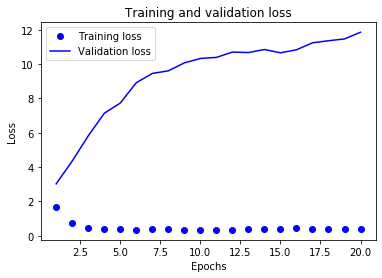

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Plot the acc and the val_acc over the epochs

<function matplotlib.pyplot.show>

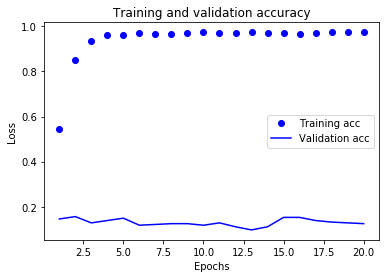

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

### Safe & plot the history
Create an empty array

In [0]:
#Only use this cell one time! If the cell is used 2 times --> reset
NN_history_loss = []
NN_history_val_loss = []

NN_history_acc = []
NN_history_val_acc = []


In [0]:
#Use the cell after every development of a model
#Safe the loss in a dic
NN_history_loss.append(loss)
NN_history_val_loss.append(val_loss)
#Safe the acc
NN_history_acc.append(acc)
NN_history_val_acc.append(val_acc)

In [0]:
id = 9
print(len(NN_history_loss), NN_history_loss[id])
print(len(NN_history_val_loss), NN_history_val_loss[id])
print(len(NN_history_acc), NN_history_acc[id])
print(len(NN_history_val_acc), NN_history_val_acc[id])

10 [2.3379789023172286, 1.186383551075345, 0.8543825390793028, 0.6391912194944563, 0.5102202988096646, 0.48587213101841153, 0.45153006059782846, 0.39060435763427187, 0.35793318333370344, 0.36212191003419103, 0.3743314678292899, 0.3567374243977524, 0.35647212456734406, 0.3804080604265134, 0.37239152902648565, 0.33745707624724935, 0.2796630283507208, 0.33244865689249264, 0.3444363066837901, 0.3219504543535766]
10 [2.5611119121313095, 3.022564575076103, 3.0050033926963806, 4.2474962174892426, 4.085292682051659, 4.952845960855484, 4.156199127435684, 4.9523899257183075, 5.3353831470012665, 4.213877111673355, 6.593425422906876, 5.99014887213707, 5.866284281015396, 6.921827107667923, 6.705359190702438, 5.0945561826229095, 7.938287317752838, 5.432408303022385, 6.411078721284866, 7.990119755268097]
10 [0.29024944152860416, 0.7003023468312763, 0.8006424719379062, 0.8512849538099199, 0.8817082302910941, 0.8953136716570173, 0.9091080725193024, 0.9223355906350272, 0.9312169182868231, 0.934807243801

Safe the results as a csv file

In [0]:
#loss
my_df = pd.DataFrame(NN_history_loss)
my_df.to_csv('NN_loss_documentation.csv', index=False, header=False)
my_df = pd.DataFrame(NN_history_val_loss)
my_df.to_csv('NN_val_loss_documentation.csv', index=False, header=False)
#Validation
my_df = pd.DataFrame(NN_history_acc)
my_df.to_csv('NN_acc_documentation.csv', index=False, header=False)
my_df = pd.DataFrame(NN_history_val_acc)
my_df.to_csv('NN_val_acc_documentation.csv', index=False, header=False)

Create 2 charts with all acc and loss over the epochs

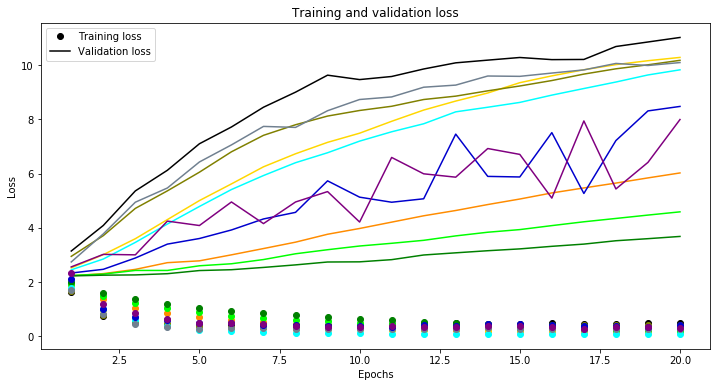

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['red','darkorange','gold','olive','lime','green','cyan','slategrey','mediumblue','purple']

loss = NN_history_loss[0]
val_loss = NN_history_val_loss[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color ='black')

for i in range(1,len(NN_history_loss)):

    loss = NN_history_loss[i]
    val_loss = NN_history_val_loss[i]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', color = farbe[i])
    plt.plot(epochs, val_loss, 'b', color = farbe [i])

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

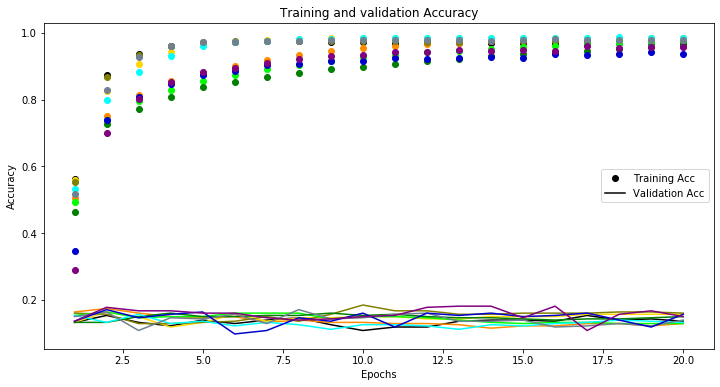

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['red','darkorange','gold','olive','lime','green','cyan','slategrey','mediumblue','purple']

loss = NN_history_acc[0]
val_loss = NN_history_val_acc[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Acc', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation Acc', color ='black')

for i in range(1,len(NN_history_acc)):

    acc = NN_history_acc[i]
    val_acc = NN_history_val_acc[i]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', color = farbe[i])
    plt.plot(epochs, val_acc, 'b', color = farbe [i])

plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

In [0]:
#Safe results in different lists to compair all the models with each other
#Safe the loss in a dic
history_loss.append(loss)
history_val_loss.append(val_loss)
#Safe the acc
history_acc.append(acc)
history_val_acc.append(val_acc)

# 2: NN with L2 Regularization
Load the packages

In [0]:
from keras import models
from keras import layers
from keras import regularizers

Define model

In [0]:
model = models.Sequential()
model.add(layers.Dense(45, kernel_regularizer = regularizers.l1(0.001), activation='relu', input_shape=(8000,)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(36,kernel_regularizer = regularizers.l1(0.001), activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(9, activation='softmax'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 45)                360045    
_________________________________________________________________
dropout_7 (Dropout)          (None, 45)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 36)                1656      
_________________________________________________________________
dropout_8 (Dropout)          (None, 36)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 9)                 333       
Total params: 362,034
Trainable params: 362,034
Non-trainable params: 0
_________________________________________________________________


Compile the model

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train the model

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=126,
                    validation_data=(x_val, y_val))

Train on 5292 samples, validate on 288 samples
Epoch 1/20
5292/5292 [==============================] - 38s 7ms/step - loss: 3.5727 - acc: 0.1999 - val_loss: 2.6595 - val_acc: 0.0903
Epoch 2/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.6082 - acc: 0.2075 - val_loss: 2.5870 - val_acc: 0.1007
Epoch 3/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.5584 - acc: 0.2012 - val_loss: 2.5648 - val_acc: 0.1181
Epoch 4/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.5117 - acc: 0.2031 - val_loss: 2.5426 - val_acc: 0.1007
Epoch 5/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.4810 - acc: 0.2162 - val_loss: 2.5251 - val_acc: 0.1042
Epoch 6/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.4520 - acc: 0.2453 - val_loss: 2.5309 - val_acc: 0.1007
Epoch 7/20
5292/5292 [==============================] - 30s 6ms/step - loss: 2.4274 - acc: 0.2538 - val_loss: 2.5545 - val_acc: 0.1111
Epoch 8/

Plot the acc and loss over the epochs

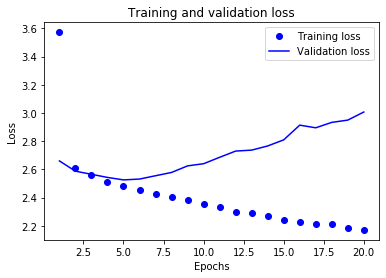

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<function matplotlib.pyplot.show>

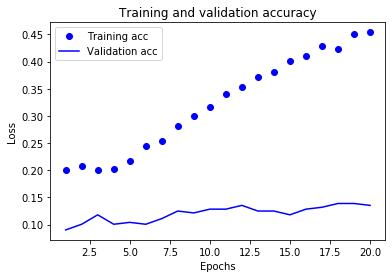

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

Safe the results

In [0]:
#Safe the loss in a dic
history_loss.append(loss)
history_val_loss.append(val_loss)
#Safe the acc
history_acc.append(acc)
history_val_acc.append(val_acc)

# 3: NN with normalized data
Normalize the data

In [0]:
import sklearn

print(x_train[1])

x_train = sklearn.preprocessing.normalize(x_train)
x_val = sklearn.preprocessing.normalize(x_val)

print(x_train[1])

Import packages

In [0]:
from keras import models
from keras import layers
from keras import regularizers

Define the model

In [0]:
model = models.Sequential()
model.add(layers.Dense(45, kernel_regularizer = regularizers.l2(0.001), activation='relu', input_shape=(8000,)))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(36,kernel_regularizer = regularizers.l2(0.001), activation='relu'))
model.add(layers.Dropout(0.4))
model.add(layers.Dense(9, activation='softmax'))

Compile model

In [0]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Train model

In [0]:
history = model.fit(x_train,
                    y_train,
                    epochs=20,
                    batch_size=126,
                    validation_data=(x_val, y_val))

Train on 5292 samples, validate on 288 samples
Epoch 1/20
5292/5292 [==============================] - 3s 524us/step - loss: 2.2627 - acc: 0.2149 - val_loss: 2.2744 - val_acc: 0.1250
Epoch 2/20
5292/5292 [==============================] - 1s 129us/step - loss: 2.1544 - acc: 0.3602 - val_loss: 2.2912 - val_acc: 0.1181
Epoch 3/20
5292/5292 [==============================] - 1s 128us/step - loss: 2.0226 - acc: 0.4475 - val_loss: 2.3331 - val_acc: 0.1076
Epoch 4/20
5292/5292 [==============================] - 1s 124us/step - loss: 1.8862 - acc: 0.5176 - val_loss: 2.3930 - val_acc: 0.1215
Epoch 5/20
5292/5292 [==============================] - 1s 114us/step - loss: 1.7485 - acc: 0.5788 - val_loss: 2.4620 - val_acc: 0.1146
Epoch 6/20
5292/5292 [==============================] - 1s 109us/step - loss: 1.6196 - acc: 0.6247 - val_loss: 2.5415 - val_acc: 0.1146
Epoch 7/20
5292/5292 [==============================] - 1s 110us/step - loss: 1.5291 - acc: 0.6601 - val_loss: 2.6141 - val_acc: 0.1215
E

Plot the acc and loss of the model over the epochs

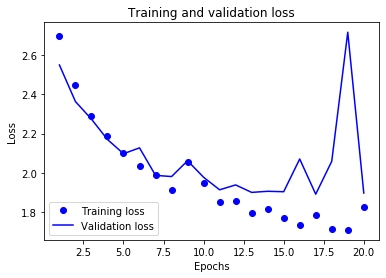

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<function matplotlib.pyplot.show>

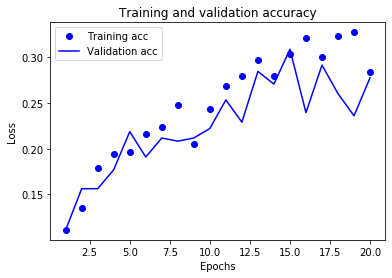

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

Safe the results

In [0]:
#Safe the loss in a dic
history_loss.append(loss)
history_val_loss.append(val_loss)
#Safe the acc
history_acc.append(acc)
history_val_acc.append(val_acc)

# 4: RNN

### Prepare the data for RNN
Take the shuffled train & val data and generate sequential mfcc data with it

['-0.027538837864995003' '-0.041832003742456436' '-0.008083789609372616'
 ... '0.0' '0.0' '0.0']
[-0.02753884 -0.041832   -0.00808379 ...  0.          0.
  0.        ]
(20, 16)


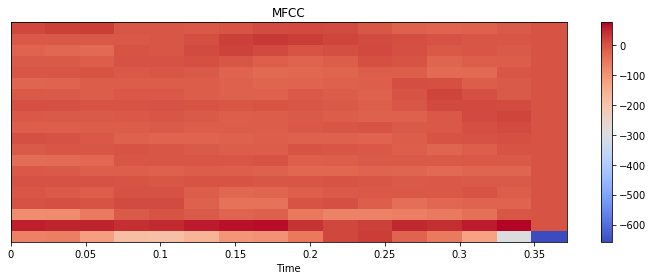

Orginal --> Max:  75.97983261703507 Min:  -657.5442147885548
Norm. --> Max:  0.5944116567289558 Min:  -0.7981803926410541


In [0]:
import sklearn

#Test
print(x_train[2])
print(x_train[2].astype(float))
test = librosa.feature.mfcc(x_train[2].astype(float),sr=8000)
#print(test)
print(test.shape)

#Plot a mfcc diagram
import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=(10, 4))
librosa.display.specshow(test, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

#Test Normalization
test_norm = sklearn.preprocessing.normalize(test)
print("Orginal --> Max: ", np.amax(test), "Min: ", np.amin(test))
print("Norm. --> Max: ", np.amax(test_norm), "Min: ", np.amin(test_norm))


In [0]:
import sklearn

#Create 2 empty lists, seq = sequential for RNN
x_seq_train = []
x_seq_val = []
x_seq_test = []

for i in range(0,len(x_train)):
    add = librosa.feature.mfcc(x_train[i].astype(float),sr=8000)
    #Normalize each element of the array
    add = sklearn.preprocessing.normalize(add)
    #Add the mfcc data to the RNN input array
    x_seq_train.append(add)



for i in range(0,len(x_val)):
    add = librosa.feature.mfcc(x_val[i].astype(float),sr=8000)
    #Normalize each element of the array
    add = sklearn.preprocessing.normalize(add)
    #Add the mfcc data to the RNN input array
    x_seq_val.append(add)

for i in range(0,len(x_test)):
    add = librosa.feature.mfcc(x_test[i].astype(float),sr=8000)
    #Normalize each element of the array
    add = sklearn.preprocessing.normalize(add)
    #Add the mfcc data to the RNN input array
    x_seq_test.append(add)


#Convert the two lists to np arrays
x_seq_train = np.array(x_seq_train)
x_seq_val = np.array(x_seq_val)
x_seq_test = np.array(x_seq_test)
#Check
print(x_seq_train.shape)
print(x_seq_val.shape)
print(x_seq_test.shape)
print("x_seq_train --> Max: ", np.amax(x_seq_train), "Min: ", np.amin(x_seq_train))
print("x_seq_val --> Max: ", np.amax(x_seq_val), "Min: ", np.amin(x_seq_val))

(5292, 20, 16)
(288, 20, 16)
(36, 20, 16)
x_seq_train --> Max:  0.9036327802705278 Min:  -0.9008842838755692
x_seq_val --> Max:  0.7653924887126192 Min:  -0.7702982526729081


### Create a LSTM-RNN

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from keras import regularizers

Using TensorFlow backend.


In [0]:
model = Sequential()

model.add(LSTM(1024, input_shape = (20,16),activation='relu', return_sequences= False))
model.add(Dropout(0.1))

model.add(Dense(9, activation='softmax'))
model.summary()

NameError: ignored

In [0]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
history = model.fit(x_seq_train,
                    y_train,
                    epochs=20,
                    batch_size=140,
                    validation_data=(x_seq_val, y_val))

Train on 5292 samples, validate on 288 samples
Epoch 1/20
5292/5292 [==============================] - 20s 4ms/sample - loss: 2.1066 - acc: 0.1793 - val_loss: 2.0641 - val_acc: 0.1875
Epoch 2/20
5292/5292 [==============================] - 16s 3ms/sample - loss: 1.9918 - acc: 0.2243 - val_loss: 2.0120 - val_acc: 0.1944
Epoch 3/20
5292/5292 [==============================] - 15s 3ms/sample - loss: 1.8524 - acc: 0.2466 - val_loss: 1.9018 - val_acc: 0.2083
Epoch 4/20
5292/5292 [==============================] - 15s 3ms/sample - loss: 1.7349 - acc: 0.3091 - val_loss: 1.8270 - val_acc: 0.2674
Epoch 5/20
5292/5292 [==============================] - 15s 3ms/sample - loss: 1.6165 - acc: 0.3753 - val_loss: 1.8809 - val_acc: 0.2639
Epoch 6/20
5292/5292 [==============================] - 15s 3ms/sample - loss: 1.4477 - acc: 0.4494 - val_loss: 1.8063 - val_acc: 0.3819
Epoch 7/20
5292/5292 [==============================] - 15s 3ms/sample - loss: 1.3908 - acc: 0.4890 - val_loss: 1.7732 - val_acc: 0

Plot the acc and loss for train and val data

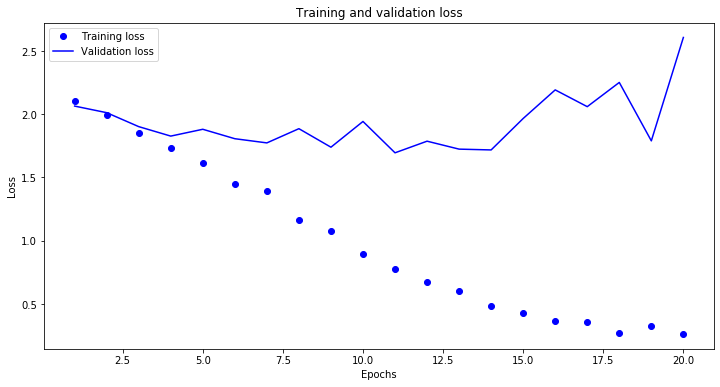

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<function matplotlib.pyplot.show>

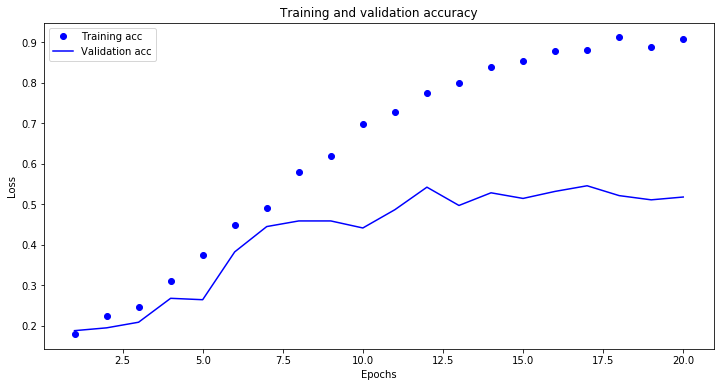

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show

### Safe & analyse the history

In [0]:
#Create 4 empty lists to safe the results of different models
RNN_history_loss = []
RNN_history_val_loss = []

RNN_history_acc = []
RNN_history_val_acc = []

In [0]:
#Use the cell after every development of a model
#Safe the loss in a dic
RNN_history_loss.append(loss)
RNN_history_val_loss.append(val_loss)
#Safe the acc
RNN_history_acc.append(acc)
RNN_history_val_acc.append(val_acc)

In [0]:
print(RNN_history_loss[1])

Plot all the results

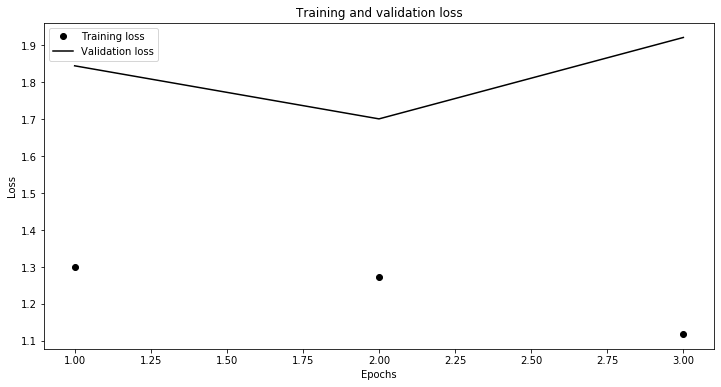

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['slategrey','mediumblue','red','green','darkorange','cyan','lime','olive','purple','gold']

loss = RNN_history_loss[0]
val_loss = RNN_history_val_loss[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation loss', color ='black')

for i in range(1,len(RNN_history_loss)):

    loss = RNN_history_loss[i]
    val_loss = RNN_history_val_loss[i]
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', color = farbe[i])
    plt.plot(epochs, val_loss, 'b', color = farbe [i])

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

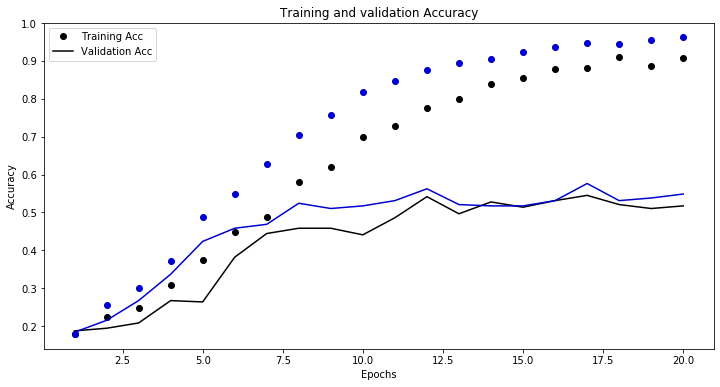

In [0]:
import matplotlib.pyplot as plt

#Create an array with colors
farbe = ['slategrey','mediumblue','red','green','darkorange','cyan','lime','olive','purple','gold']

loss = RNN_history_acc[0]
val_loss = RNN_history_val_acc[0]
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training Acc', color = 'black')
plt.plot(epochs, val_loss, 'b', label='Validation Acc', color ='black')

for i in range(1,len(RNN_history_acc)):

    acc = RNN_history_acc[i]
    val_acc = RNN_history_val_acc[i]
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', color = farbe[i])
    plt.plot(epochs, val_acc, 'b', color = farbe [i])

plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.rcParams['figure.figsize'] = (12,6)
plt.show()

## Create a GRU
Import packages

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU
from keras import regularizers
import keras


Define and compile the model

In [0]:
model = Sequential()

model.add(GRU(1024, input_shape = (20,16),activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(512,activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(256, activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(128, activation='relu', return_sequences= True))
model.add(Dropout(0.1))

model.add(GRU(64, activation='relu',return_sequences= False))
model.add(Dropout(0.1))

model.add(Dense(9, activation='softmax'))
model.summary()

model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_25 (GRU)                 (None, 20, 368)           425040    
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 368)           0         
_________________________________________________________________
gru_26 (GRU)                 (None, 20, 298)           596298    
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 298)           0         
_________________________________________________________________
gru_27 (GRU)                 (None, 20, 228)           360468    
_________________________________________________________________
dropout_27 (Dropout)         (None, 20, 228)           0         
_________________________________________________________________
gru_28 (GRU)                 (None, 20, 158)          

Train the model

In [0]:
history = model.fit(x_seq_train,
                    y_train,
                    epochs=15,
                    batch_size=126,
                    validation_data=(x_seq_val, y_val))

Plot the acc and loss of the model over the epochs

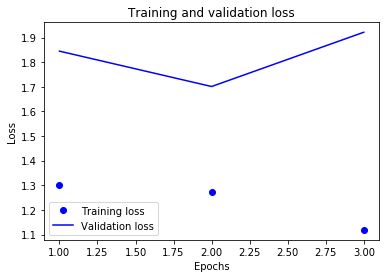

In [0]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<function matplotlib.pyplot.show>

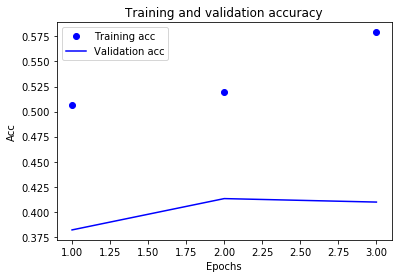

In [0]:
#Clear the figure
plt.clf

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show

Show network architecture

In [0]:
from keras.utils import plot_model

tf.keras.utils.plot_model(model, to_file='model_combined.png')

## Safe/ load the model

In [0]:
from keras.models import load_model
model.save('own_data_model.h5')

In [0]:
from tensorflow.keras.models import load_model
model = load_model('own_data_model.h5')

## Test the model and create a confusion matrix


Test the model

In [0]:
y_pred = model.predict(x_seq_test)
print(y_pred.shape)


(36, 9)


Create a confusion matrix

[[0.   0.   0.   0.   0.5  0.   0.   0.   0.5 ]
 [0.   0.   0.   0.   0.   0.5  0.   0.   0.5 ]
 [0.   0.   0.   0.5  0.   0.5  0.   0.   0.  ]
 [0.25 0.25 0.   0.   0.   0.25 0.25 0.   0.  ]
 [0.   0.   0.   0.   0.25 0.   0.25 0.   0.5 ]
 [0.5  0.   0.   0.25 0.   0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.   0.25 0.25 0.   0.5 ]
 [0.   0.   0.   0.   0.   0.   0.5  0.   0.5 ]
 [0.   0.   0.   0.   0.   0.   0.5  0.   0.5 ]]


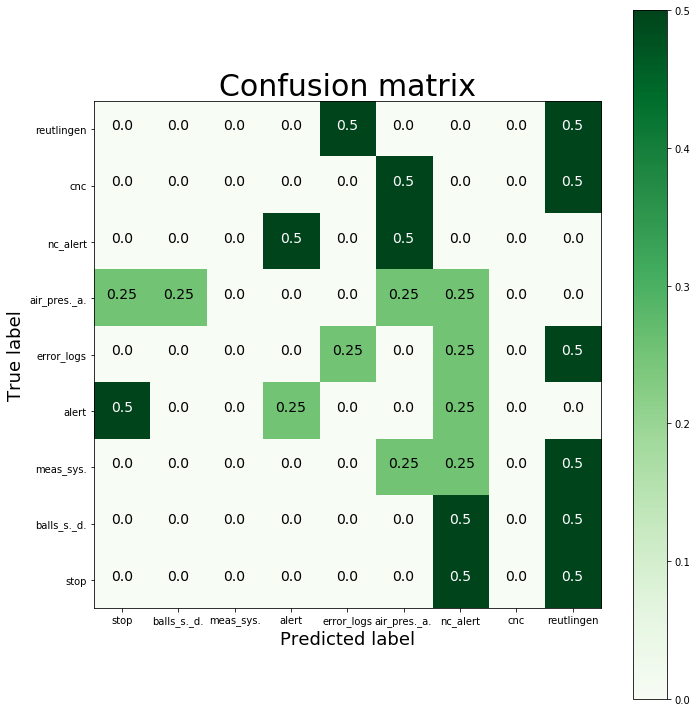

In [0]:
#Import packages
from sklearn.metrics import multilabel_confusion_matrix
from sklearn import preprocessing
from mlxtend.evaluate import confusion_matrix

#Create the confusion matrix
cm = confusion_matrix(y_target=y_true_str, 
                              y_predicted = y_pred_str, 
                              binary=False)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print(cm)


import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



#Define a func for the confusion matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Greens):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    plt.xticks(np.arange(9), ('stop','balls_s._d.','meas_sys.', 'alert','error_logs','air_pres._a.','nc_alert','cnc','reutlingen'))
    plt.yticks(np.arange(9), ('reutlingen','cnc','nc_alert','air_pres._a.', 'error_logs','alert','meas_sys.','balls_s._d.','stop'))
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 fontsize=14,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', fontsize=18)
    plt.xlabel('Predicted label', fontsize=18)


#Plot the matrix
fig, ax = plt.subplots()
plot_confusion_matrix(cm)
plt.rcParams['figure.figsize'] = (10,10)
plt.show()



Safe the model as h5 file

In [0]:
from keras.models import load_model

model.save('own_data_model.h5')

Load the model

In [0]:
from keras.models import load_model

model = load_model('own_data_model.h5')